# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

# here and later fix the random state to have reproducable results
random_state = 42

Let's generate our dataset and take a look on it.

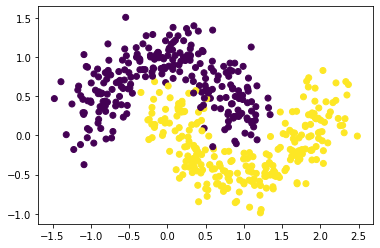

In [2]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=random_state)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from mlxtend.plotting import plot_decision_regions

lr = LogisticRegression(C=1)# add some params
svm = SVC(kernel='linear', C=0.01) # here too

lr.fit(moons_points, moons_labels)
svm.fit(moons_points, moons_labels)

# generating test sample
X_test, y_test = make_moons(n_samples=50, noise=0.2, random_state=random_state)

### YOUR CODE HERE
def plot_decisions(X, y, clf, title):
    fig = plt.figure(figsize=(7,5))
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(title)
    plt.show()

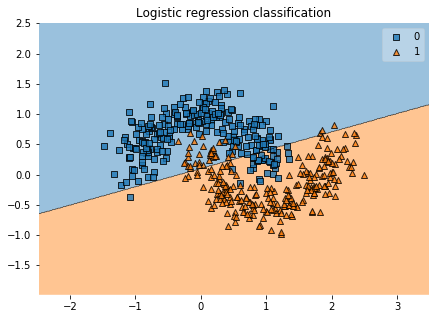

f1 score: 0.8461538461538461


In [4]:
plot_decisions(moons_points, moons_labels, lr, "Logistic regression classification")
print("f1 score:", metrics.f1_score(lr.predict(X_test), y_test))

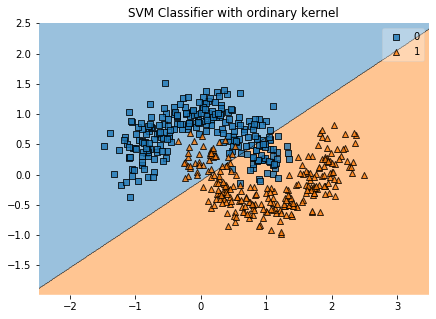

f1 score: 0.816326530612245


In [5]:
plot_decisions(moons_points, moons_labels, svm, "SVM Classifier with ordinary kernel")
print("f1 score:", metrics.f1_score(svm.predict(X_test), y_test))

#### Summary:
- Both models show not bad score, but they can't catch a non-linear pattern in the data, this is their main problem in this sample

- I've choosed regularization params to make models less complicated
    - SVM loss function: $\frac{1}{C}\|{w}\|^2 + \sum max(0, 1-M_i)$. We should take low $C$ to maximize gap $\frac{2}{\|{w}\|}$
    - Log regr loss function: $\sum \log(1-\exp(-M_i)) + C\|{w}\|^2$. We should take high $C$ to make model less complicated

## 1.2 Kernel tirck

![keep-calm](imgs/keep-calm.jpg)

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

In [6]:
from sklearn import model_selection

#### Validate models with cross validation with stratified shuffle split

In [7]:
cv = model_selection.StratifiedShuffleSplit(n_splits=4, test_size=0.2, random_state=random_state)
parameters_grid = {
    "C" : np.linspace(0, 4, num=100)
}

In [8]:
def ValidatePolyKernelSVM(degree, plot=True):
    grid_cv = model_selection.GridSearchCV(SVC(kernel="poly", degree=degree), parameters_grid, scoring="f1", cv=cv, n_jobs=8)
    grid_cv.fit(moons_points, moons_labels)
    
    if plot:
        print("best estimator for SVM poly kernel params:", grid_cv.best_params_)
        plot_decisions(moons_points, moons_labels, grid_cv.best_estimator_,
                       "SVM Classifier with poly kernel degree={}".format(grid_cv.best_estimator_.degree))
    
    return metrics.f1_score(grid_cv.best_estimator_.predict(X_test), y_test)
    
def ValidateRBFKernelSVM():
    grid_cv = model_selection.GridSearchCV(SVC(kernel="rbf"), parameters_grid, scoring="f1", cv=cv, n_jobs=8)
    grid_cv.fit(moons_points, moons_labels)

    print("best estimator for SVM rbf kernel params:", grid_cv.best_params_)
    plot_decisions(moons_points, moons_labels, grid_cv.best_estimator_, "SVM Classifier with rbf kernel")
   
    return metrics.f1_score(grid_cv.best_estimator_.predict(X_test), y_test)
    
def ValidateSigmoidSVM():
    grid_cv = model_selection.GridSearchCV(SVC(kernel="sigmoid"), parameters_grid, scoring="f1", cv=cv, n_jobs=8)
    grid_cv.fit(moons_points, moons_labels)

    print("best estimator for SVM sigmoid kernel params:", grid_cv.best_params_)
    plot_decisions(moons_points, moons_labels, grid_cv.best_estimator_, "SVM Classifier with sigmoid kernel")
        
    return metrics.f1_score(grid_cv.best_estimator_.predict(X_test), y_test)

### Find best polynomial kernel degree

In [9]:
degree = np.arange(1, 12)

f1 = np.array([ValidatePolyKernelSVM(i, plot=False) for i in degree])
best_degree = degree[np.argmax(f1)]

print("kernel degree with best score:", best_degree)

kernel degree with best score: 5


best estimator for SVM poly kernel params: {'C': 3.7979797979797985}


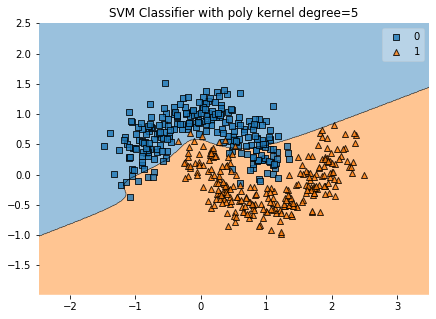

f1: 0.8771929824561403


In [10]:
f1 = ValidatePolyKernelSVM(degree=5)

print("f1:", f1)

best estimator for SVM rbf kernel params: {'C': 3.8383838383838387}


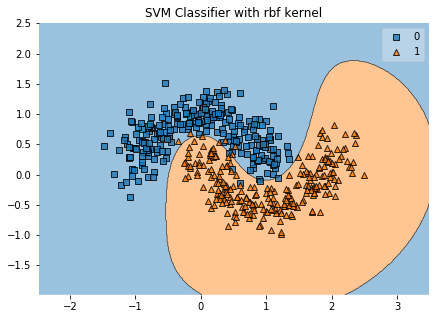

f1:  0.9411764705882353


In [11]:
f1 = ValidateRBFKernelSVM()

print("f1: ", f1)

best estimator for SVM sigmoid kernel params: {'C': 0.04040404040404041}


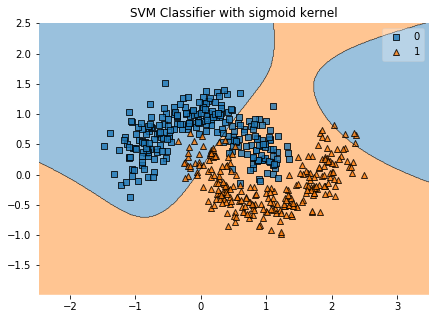

f1:  0.8070175438596492


In [12]:
f1 = ValidateSigmoidSVM()

print("f1: ", f1)

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?
#### Summary:

- Choosed $f1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$ metric, to increase both precision and recall
- Classification quality grew up for rbf and polynomial kernel
- We see 5th degree curve as border for polynomial kernel, blob for rbf kernel and smth that should look like $\tanh$ for sigmoid kernel
- I've choosed 5th degree as it shows best results at CV

## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

In [13]:
from sklearn.preprocessing import PolynomialFeatures
### YOUR CODE HERE

poly = PolynomialFeatures(degree=5, include_bias=False)
poly.fit(moons_points)

moons_poly_points = poly.transform(moons_points)
X_test_poly = poly.transform(X_test)

lr = LogisticRegression()
lr.fit(moons_poly_points, moons_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Logistic regression on polynomial features:


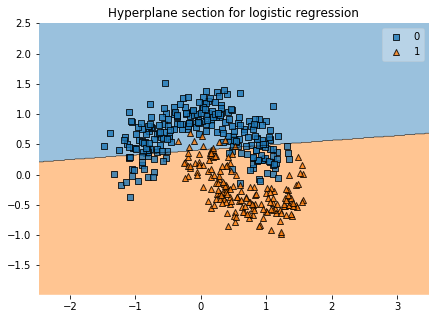

f1: 0.9615384615384615


In [14]:
print("Logistic regression on polynomial features:")
fig = plt.figure(figsize=(7,5))

# can't find pretty looking section for hypersurface, so plot might be uninformative
value = 0.1
width = 10

fig = plot_decision_regions(X=moons_poly_points, y=moons_labels, clf=lr, feature_index=(0, 1),
                           filler_feature_values={i : value for i in range(2, moons_poly_points.shape[1])},
                           filler_feature_ranges={i : width for i in range(2, moons_poly_points.shape[1])})
plt.title("Hyperplane section for logistic regression")
plt.show()
print("f1:", metrics.f1_score(lr.predict(X_test_poly), y_test))

#### Summary: 

- Both logistic regression on polynomial features and svm with polynomial kernel build curve dividing surface in feature space

- Logistic regression over polynomial feature shows better f1 score than SVM with poly kernel degree=5

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

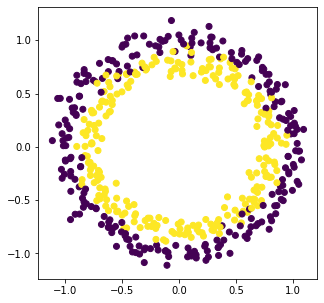

In [18]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=random_state)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)

In [19]:
circles_train, circles_labels_train, circles_test, circles_labels_test = model_selection.train_test_split(circles_points, circles_labels, test_size=0.2)

And even more:

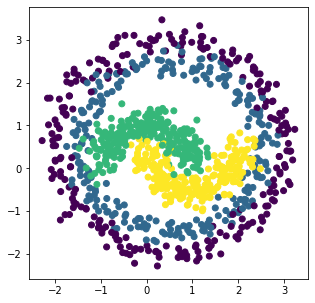

In [16]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels)

In [20]:
points_train, labels_train, points_test, labels_test = model_selection.train_test_split(points, labels, test_size=0.2)

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

#### First of all lets try RandomForest for both datasets as baseline

In [21]:
from sklearn.ensemble import RandomForestClassifier